# ## 1. Cargar imagen original

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar imagen

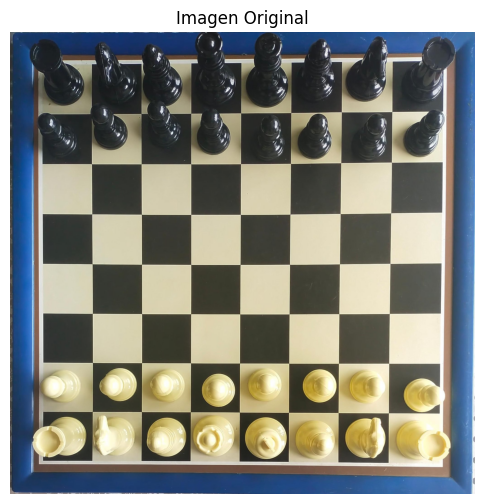

In [69]:
img = cv2.imread('Tablero_mejor.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.title('Imagen Original')
plt.axis('off')
plt.show()

# ## 2. Preprocesado de la imagen
# Convertir a escala de grises y aplicar filtros

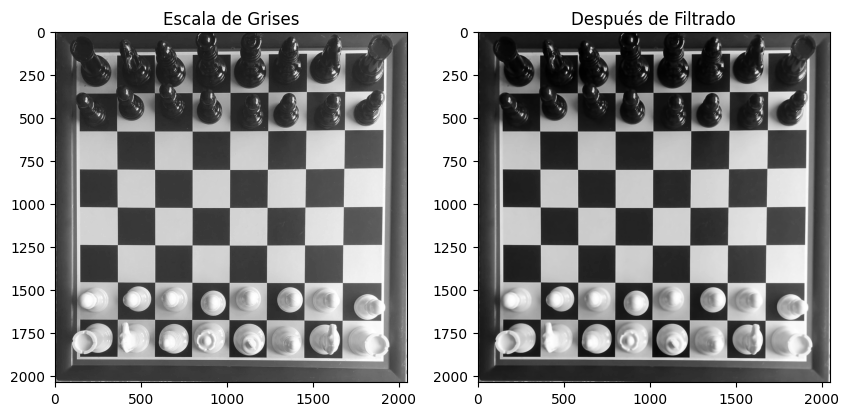

In [70]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.bilateralFilter(gray, 11, 50, 50)  # Parámetros mejorados

plt.figure(figsize=(10,6))
plt.subplot(121), plt.imshow(gray, cmap='gray'), plt.title('Escala de Grises')
plt.subplot(122), plt.imshow(blur, cmap='gray'), plt.title('Después de Filtrado')
plt.show()

## 3. Detección de bordes

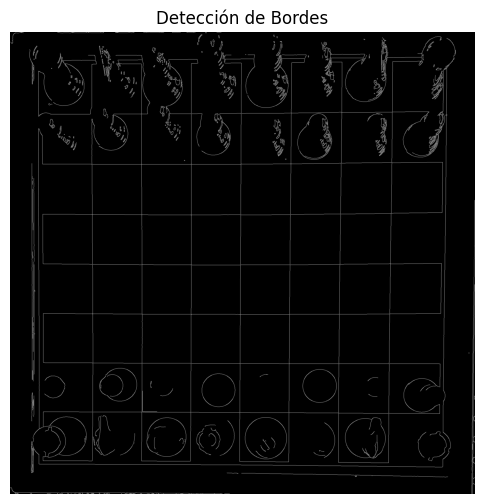

In [71]:
edges = cv2.Canny(blur, 30, 100)  # Umbrales reducidos

plt.figure(figsize=(10,6))
plt.imshow(edges, cmap='gray')
plt.title('Detección de Bordes')
plt.axis('off')
plt.show()


## 4. Detección de líneas

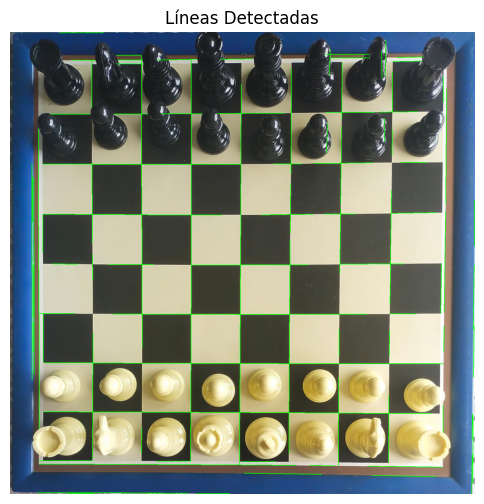

In [ ]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, 
                        minLineLength=100, maxLineGap=30)

# Dibujar líneas detectadas
line_img = img.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1,y1), (x2,y2), (0,255,0), 2)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.title('Líneas Detectadas')
plt.axis('off')
plt.show()

In [73]:
## 5. Filtrar líneas y encontrar intersecciones

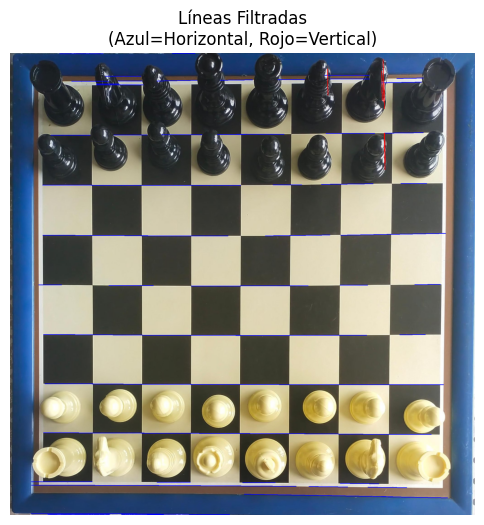

In [74]:
horizontal = []
vertical = []

for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
    
    if abs(angle) < 5:  # Horizontal
        horizontal.append(line)
    elif abs(angle - 90) < 5:  # Vertical
        vertical.append(line)

# Dibujar líneas filtradas
filtered_lines = img.copy()
for h in horizontal:
    x1, y1, x2, y2 = h[0]
    cv2.line(filtered_lines, (x1,y1), (x2,y2), (255,0,0), 2)
for v in vertical:
    x1, y1, x2, y2 = v[0]
    cv2.line(filtered_lines, (x1,y1), (x2,y2), (0,0,255), 2)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(filtered_lines, cv2.COLOR_BGR2RGB))
plt.title('Líneas Filtradas\n(Azul=Horizontal, Rojo=Vertical)')
plt.axis('off')
plt.show()

## 6. Encontrar esquinas del tablero

In [75]:
points = []
for h in horizontal[:20]:  # Limitar a primeras 20 líneas
    for v in vertical[:20]:
        x = int((h[0][0] + v[0][0])/2)
        y = int((h[0][1] + v[0][1])/2)
        points.append([x, y])

if len(points) < 4:
    raise ValueError("Insuficientes puntos de intersección detectados")

points = np.array(points, dtype=np.float32)  # Conversión directa a float32


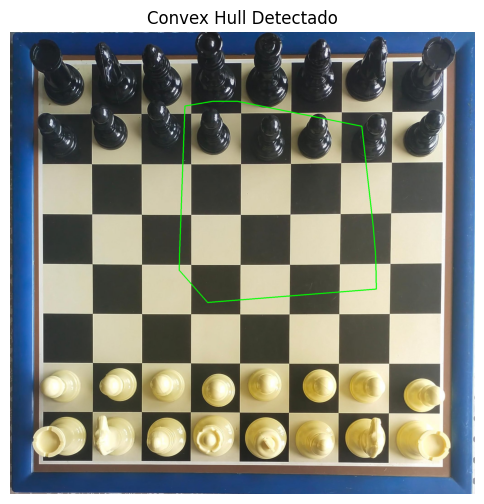

In [76]:
try:
    hull = cv2.convexHull(points)
except cv2.error as e:
    raise RuntimeError(f"Error en convexHull: {str(e)}. Verifica los puntos detectados") from e

# Dibujar convex hull
hull_img = img.copy()
cv2.drawContours(hull_img, [hull.astype(int)], -1, (0,255,0), 3)

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(hull_img, cv2.COLOR_BGR2RGB))
plt.title('Convex Hull Detectado')
plt.axis('off')
plt.show()


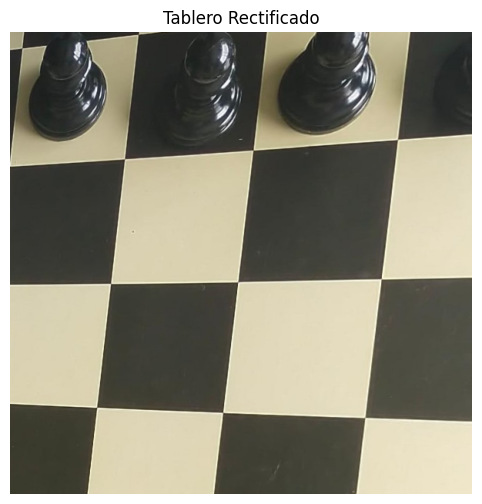

In [77]:
def ordenar_esquinas(puntos):
    # Implementación robusta
    rect = np.zeros((4, 2), dtype=np.float32)
    suma = puntos.sum(axis=1)
    rect[0] = puntos[np.argmin(suma)]
    rect[2] = puntos[np.argmax(suma)]
    
    diferencia = np.diff(puntos, axis=1)
    rect[1] = puntos[np.argmin(diferencia)]
    rect[3] = puntos[np.argmax(diferencia)]
    return rect

try:
    esquinas_ordenadas = ordenar_esquinas(hull.squeeze())
except ValueError as e:
    raise RuntimeError("Error al ordenar esquinas. ¿Forma correcta del hull?") from e

tamaño = 600
warped = cv2.warpPerspective(img,
                            cv2.getPerspectiveTransform(esquinas_ordenadas,
                                                       np.float32([[0,0],[tamaño,0],[tamaño,tamaño],[0,tamaño]])),
                            (tamaño, tamaño))

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Tablero Rectificado')
plt.axis('off')
plt.show()


In [78]:
cell_size = tamaño // 8
ocupacion = []

for fila in range(8):
    fila_ocupacion = []
    for col in range(8):
        y1 = fila * cell_size + 5  # Margen interno
        y2 = (fila+1) * cell_size - 5
        x1 = col * cell_size + 5
        x2 = (col+1) * cell_size -5
        
        casilla = warped[y1:y2, x1:x2]
        gris = cv2.cvtColor(casilla, cv2.COLOR_BGR2GRAY)
        
        # Detección adaptativa
        _, thresh = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        porcentaje_ocupacion = np.sum(thresh == 255) / thresh.size
        
        fila_ocupacion.append(1 if porcentaje_ocupacion > 0.25 else 0)
    
    ocupacion.append(fila_ocupacion)

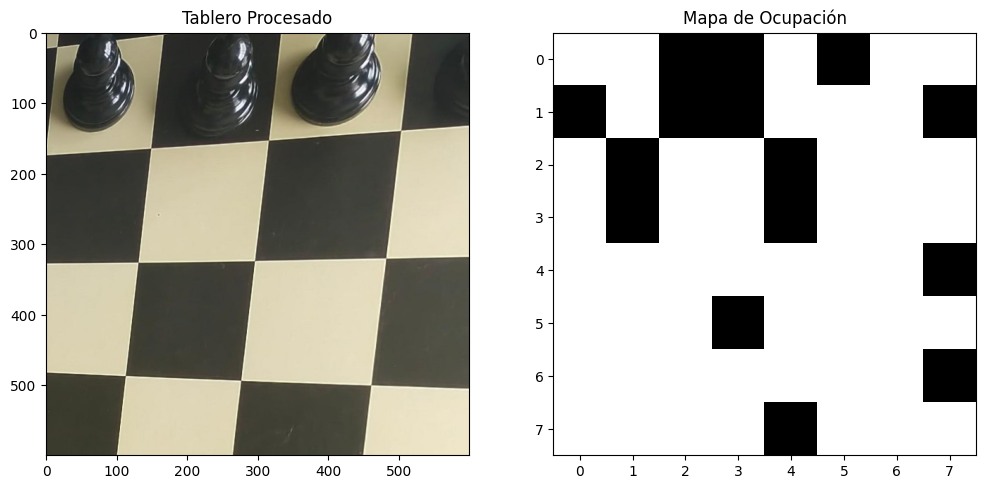

Matriz de ocupación (1 = pieza presente):
1 1 0 0 1 0 1 1
0 1 0 0 1 1 1 0
1 0 1 1 0 1 1 1
1 0 1 1 0 1 1 1
1 1 1 1 1 1 1 0
1 1 1 0 1 1 1 1
1 1 1 1 1 1 1 0
1 1 1 1 0 1 1 1


In [79]:
plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)), plt.title('Tablero Procesado')
plt.subplot(122), plt.imshow(np.array(ocupacion, dtype=np.uint8)*255, cmap='gray')
plt.title('Mapa de Ocupación')
plt.show()

print("Matriz de ocupación (1 = pieza presente):")
for fila in ocupacion:
    print(" ".join(map(str, fila)))